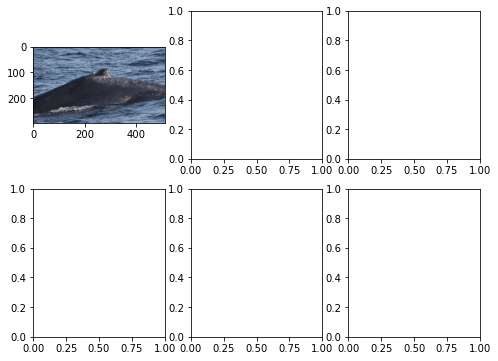

In [1]:
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

train_df = pd.read_csv('data/train_kfold.csv')
img_dir = 'D:/whalefull/working/data/train_images'
# img_dir = '/Users/macbook/works/train_images-384-384'
ids = train_df[train_df.sample_count == 1].individual_id.unique()

def random_show(train_df):
    iid = np.random.choice(ids)
    samples = train_df[train_df.individual_id == iid]
    imgs = []
    for i, row in samples.iterrows():
        img = cv2.imread(f'{img_dir}/{row.image}')[:, :, ::-1]
        if img is not None:
            imgs.append(img)

    fig = plt.figure(figsize=(8, 6))
    columns = 3
    rows = 2
    for i in range(0, columns*rows):
        fig.add_subplot(rows, columns, i+1)
        if i < len(imgs):
            
            plt.imshow(imgs[i])
    plt.show()

random_show(train_df)

In [2]:
x = pd.read_csv('data/train_image_size.csv')
x['r'] = x.w / x.h
x = x.sort_values('h')

,Unnamed: 0,image,h,w,r
42728,42728,8a1924e8bb4143.jpg,41,180,4.390244
49907,49907,f640359d036539.jpg,42,304,7.238095
18650,18650,c6e133317f4ce6.jpg,45,154,3.422222
37818,37818,a0cbb72ef31aa3.jpg,46,205,4.456522
24039,24039,b975838988f041.jpg,47,172,3.659574
...,...,...,...,...,...
1301,1301,f461e90a1a0909.jpg,5277,3599,0.682016
13032,13032,f75296ec47f806.jpg,5277,3599,0.682016
48074,48074,015b9c7df6b33a.jpg,5277,3599,0.682016
41469,41469,99c03bb23874cd.jpg,5399,3599,0.666605


In [3]:
len(x[x['r'] >= 3])

9768

15


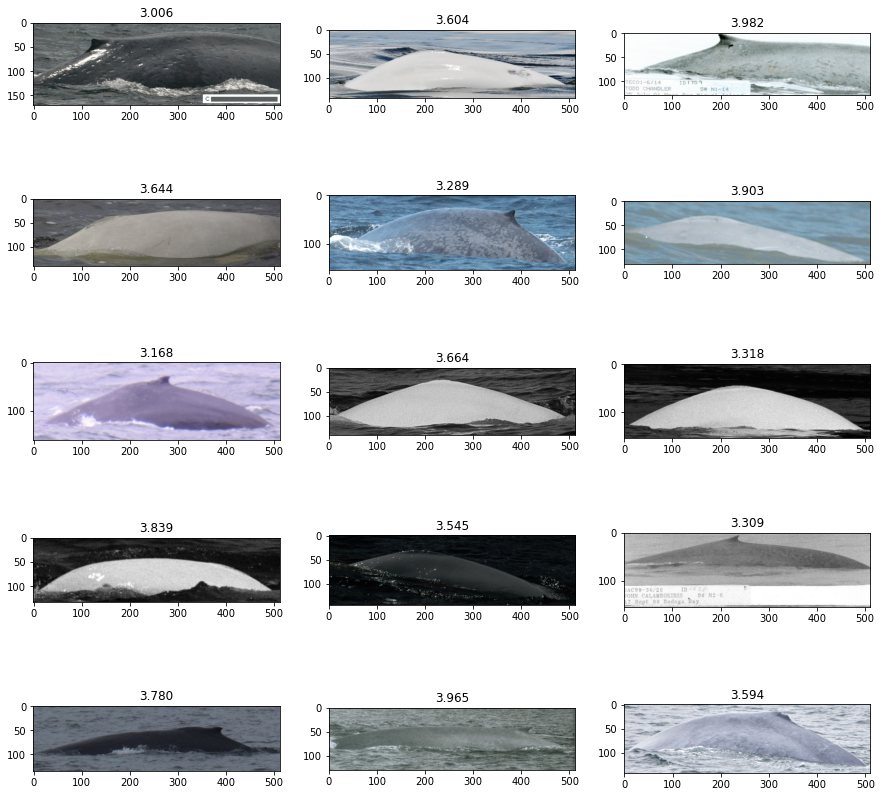

In [4]:
# Show some dataset
imgs = []
for i, row in x[(x['r'] >= 3) & (x['r'] <=4)].sample(100).iterrows():
    img = cv2.imread(img_dir + '/' + row.image)
    if img is not None:
        imgs.append([img[:,:,::-1], row['r']])

    if len(imgs)  == 15:
        break

print(len(imgs))
fig = plt.figure(figsize=(15, 15))
columns = 3
rows = 5
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    im, r = imgs[i-1]
    plt.title(f"{r:.3f}")
    plt.imshow(im)
plt.show()

In [7]:
plt.imshow(cv2.imread(f"{img_dir}/3aa9888f58.jpg")[:,:,::-1])

TypeError: 'NoneType' object is not subscriptable